In [ ]:
import os
import kagglehub
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split
from PIL import Image
from tensorflow.keras import layers, models
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.utils import image_dataset_from_directory
from sklearn.metrics import classification_report, confusion_matrix
import itertools

import pandas as pd


In [ ]:

import kagglehub

data_root = kagglehub.dataset_download("daniilonishchenko/mushrooms-images-classification-215")
print("Dataset root:", data_root)

def find_species_folder(root):
    for dirpath, dirnames, filenames in os.walk(root):

        if len(dirnames) > 100:
            print("Detected species folder:", dirpath)
            return dirpath
    raise ValueError("Could not locate species folder automatically.")

image_root_path = find_species_folder(data_root)
class_folders = sorted(os.listdir(image_root_path))
print("Number of raw classes:", len(class_folders))
print("Example classes:", class_folders[:10])


Dataset root: C:\Users\arpit\.cache\kagglehub\datasets\daniilonishchenko\mushrooms-images-classification-215\versions\2
Detected species folder: C:\Users\arpit\.cache\kagglehub\datasets\daniilonishchenko\mushrooms-images-classification-215\versions\2\data\data
Number of raw classes: 215
Example classes: ['almond_mushroom', 'amanita_gemmata', 'amethyst_chanterelle', 'amethyst_deceiver', 'aniseed_funnel', 'ascot_hat', 'bay_bolete', 'bearded_milkcap', 'beechwood_sickener', 'beefsteak_fungus']


In [ ]:

file_paths = []
labels = []

for idx, cls in enumerate(class_folders):
    cls_folder = os.path.join(image_root_path, cls)
    for fname in os.listdir(cls_folder):
        fpath = os.path.join(cls_folder, fname)
        if os.path.isfile(fpath):
            file_paths.append(fpath)
            labels.append(cls)

df = pd.DataFrame({"filepath": file_paths, "label": labels})
print("Total images before filtering:", len(df))

# Drop rare classes with very few images (e.g., < 10)
min_images_per_class = 10
counts = df["label"].value_counts()
keep_labels = counts[counts >= min_images_per_class].index.tolist()
df = df[df["label"].isin(keep_labels)].reset_index(drop=True)

print("Classes kept (>= %d images): %d" % (min_images_per_class, len(keep_labels)))
print("Total images after filtering:", len(df))
print(df['label'].value_counts().head())


Total images before filtering: 3122
Classes kept (>= 10 images): 210
Total images after filtering: 3085
label
deadly_fibrecap        16
meadow_waxcap          15
scarlet_waxcap         15
powdery_brittlegill    15
purple_brittlegill     15
Name: count, dtype: int64


In [ ]:


from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
df["label_idx"] = le.fit_transform(df["label"])
num_classes = df["label_idx"].nunique()
print("Encoded classes:", num_classes)

X = df["filepath"].values
y = df["label_idx"].values

X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.4, random_state=42, stratify=y
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)

print("Train size:", len(X_train))
print("Val size:  ", len(X_val))
print("Test size: ", len(X_test))


Encoded classes: 210
Train size: 1851
Val size:   617
Test size:  617


In [ ]:

img_size = (224, 224)
batch_size = 32
AUTOTUNE = tf.data.AUTOTUNE

def load_image(path, label):
    # read file
    img = tf.io.read_file(path)
    img = tf.image.decode_image(img, channels=3, expand_animations=False)
    img = tf.image.resize(img, img_size)
    img = tf.cast(img, tf.float32)
    return img, label

train_paths_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train))
val_paths_ds   = tf.data.Dataset.from_tensor_slices((X_val, y_val))
test_paths_ds  = tf.data.Dataset.from_tensor_slices((X_test, y_test))

train_ds_raw = train_paths_ds.map(load_image, num_parallel_calls=AUTOTUNE)
val_ds_raw   = val_paths_ds.map(load_image, num_parallel_calls=AUTOTUNE)
test_ds_raw  = test_paths_ds.map(load_image, num_parallel_calls=AUTOTUNE)


In [ ]:


data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
    layers.RandomContrast(0.2),
])

def preprocess_train(img, label):
    img = data_augmentation(img)
    img = preprocess_input(img)
    label = tf.one_hot(label, depth=num_classes)
    return img, label

def preprocess_eval(img, label):
    img = preprocess_input(img)
    label = tf.one_hot(label, depth=num_classes)
    return img, label

train_ds = (train_ds_raw
            .map(preprocess_train, num_parallel_calls=AUTOTUNE)
            .shuffle(2000)
            .batch(batch_size)
            .prefetch(AUTOTUNE))

val_ds = (val_ds_raw
          .map(preprocess_eval, num_parallel_calls=AUTOTUNE)
          .batch(batch_size)
          .prefetch(AUTOTUNE))

test_ds = (test_ds_raw
           .map(preprocess_eval, num_parallel_calls=AUTOTUNE)
           .batch(batch_size)
           .prefetch(AUTOTUNE))

for images, labels in train_ds.take(1):
    print("Train batch image shape:", images.shape)
    print("Train batch label shape:", labels.shape)
    break


Train batch image shape: (32, 224, 224, 3)
Train batch label shape: (32, 210)


In [ ]:


class_counts = df['label_idx'].value_counts().to_dict()
total_samples = len(df)
class_weights = {}

for cls_idx, count in class_counts.items():
    class_weights[cls_idx] = total_samples / (num_classes * count)

print("Example class weights (first 10):")
for k in sorted(class_weights.keys())[:10]:
    print(k, "->", class_weights[k])


Example class weights (first 10):
0 -> 1.2242063492063493
1 -> 0.9793650793650793
2 -> 0.9793650793650793
3 -> 0.9793650793650793
4 -> 0.9793650793650793
5 -> 0.9793650793650793
6 -> 0.9793650793650793
7 -> 0.9793650793650793
8 -> 0.9793650793650793
9 -> 0.9793650793650793


In [ ]:

#build resnet50

input_shape = img_size + (3,)

base_model = ResNet50(
    weights="imagenet",
    include_top=False,
    input_shape=input_shape
)
base_model.trainable = False

inputs = layers.Input(shape=input_shape)
x = base_model(inputs, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.4)(x)
outputs = layers.Dense(num_classes, activation="softmax")(x)

model = models.Model(inputs, outputs)

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

model.summary()


Model: "model_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_20 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d_9   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dropout_9 (Dropout)         (None, 2048)              0         
                                                                 
 dense_9 (Dense)             (None, 210)               430290    
                                                                 
Total params: 24,018,002
Trainable params: 430,290
Non-trainable params: 23,587,712
_________________________________________

In [ ]:
# train classifier

from tensorflow.keras.callbacks import ReduceLROnPlateau
epochs_frozen =50

early_stop = EarlyStopping(monitor="val_loss", patience=4, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=2, verbose=1)
checkpoint = ModelCheckpoint("best_resnet50_highacc.h5", monitor="val_loss",
                             save_best_only=True, verbose=1)

history_frozen = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs_frozen,
    callbacks=[early_stop, reduce_lr, checkpoint],
    class_weight=class_weights
)


Epoch 1/50
58/58 [==============================] - ETA: 0s - loss: 6.3613 - accuracy: 0.0032
Epoch 1: val_loss improved from inf to 5.42004, saving model to best_resnet50_highacc.h5
58/58 [==============================] - 16s 152ms/step - loss: 6.3613 - accuracy: 0.0032 - val_loss: 5.4200 - val_accuracy: 0.0162 - lr: 1.0000e-04
Epoch 2/50
58/58 [==============================] - ETA: 0s - loss: 5.6167 - accuracy: 0.0200
Epoch 2: val_loss improved from 5.42004 to 5.00066, saving model to best_resnet50_highacc.h5
58/58 [==============================] - 15s 159ms/step - loss: 5.6167 - accuracy: 0.0200 - val_loss: 5.0007 - val_accuracy: 0.0470 - lr: 1.0000e-04
Epoch 3/50
58/58 [==============================] - ETA: 0s - loss: 5.1290 - accuracy: 0.0357
Epoch 3: val_loss improved from 5.00066 to 4.66540, saving model to best_resnet50_highacc.h5
58/58 [==============================] - 15s 152ms/step - loss: 5.1290 - accuracy: 0.0357 - val_loss: 4.6654 - val_accuracy: 0.0924 - lr: 1.0000e

In [ ]:

# ine tuninh

fine_tune_at = 140
base_model.trainable = True

for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

epochs_finetune = 50

history_finetune = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs_finetune,
    callbacks=[early_stop, reduce_lr, checkpoint],
    class_weight=class_weights
)


Epoch 1/50
58/58 [==============================] - ETA: 0s - loss: 0.0947 - accuracy: 0.9865
Epoch 1: val_loss did not improve from 1.79305
58/58 [==============================] - 16s 164ms/step - loss: 0.0947 - accuracy: 0.9865 - val_loss: 1.9030 - val_accuracy: 0.6013 - lr: 1.0000e-05
Epoch 2/50
58/58 [==============================] - ETA: 0s - loss: 0.0491 - accuracy: 0.9924
Epoch 2: val_loss did not improve from 1.79305
58/58 [==============================] - 12s 152ms/step - loss: 0.0491 - accuracy: 0.9924 - val_loss: 1.9303 - val_accuracy: 0.5883 - lr: 1.0000e-05
Epoch 3/50
58/58 [==============================] - ETA: 0s - loss: 0.0436 - accuracy: 0.9919
Epoch 3: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-06.

Epoch 3: val_loss did not improve from 1.79305
58/58 [==============================] - 12s 148ms/step - loss: 0.0436 - accuracy: 0.9919 - val_loss: 1.9743 - val_accuracy: 0.5916 - lr: 1.0000e-05
Epoch 4/50
58/58 [==============================] - E

In [ ]:
'''
def plot_history(hist, title):
    acc = hist.history.get("accuracy", [])
    val_acc = hist.history.get("val_accuracy", [])
    loss = hist.history.get("loss", [])
    val_loss = hist.history.get("val_loss", [])

    plt.figure(figsize=(12,4))
    plt.subplot(1,2,1)
    plt.plot(acc, label="Train")
    plt.plot(val_acc, label="Val")
    plt.title(title + " Accuracy")
    plt.legend()

    plt.subplot(1,2,2)
    plt.plot(loss, label="Train")
    plt.plot(val_loss, label="Val")
    plt.title(title + " Loss")
    plt.legend()

    plt.show()

plot_history(history_frozen, "Frozen Base")
plot_history(history_finetune, "Fine-Tuned")

'''

'\ndef plot_history(hist, title):\n    acc = hist.history.get("accuracy", [])\n    val_acc = hist.history.get("val_accuracy", [])\n    loss = hist.history.get("loss", [])\n    val_loss = hist.history.get("val_loss", [])\n\n    plt.figure(figsize=(12,4))\n    plt.subplot(1,2,1)\n    plt.plot(acc, label="Train")\n    plt.plot(val_acc, label="Val")\n    plt.title(title + " Accuracy")\n    plt.legend()\n\n    plt.subplot(1,2,2)\n    plt.plot(loss, label="Train")\n    plt.plot(val_loss, label="Val")\n    plt.title(title + " Loss")\n    plt.legend()\n\n    plt.show()\n\nplot_history(history_frozen, "Frozen Base")\nplot_history(history_finetune, "Fine-Tuned")\n\n'

In [ ]:

# evaluate on testb set

test_loss, test_acc = model.evaluate(test_ds)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_acc)


20/20 [==============================] - 2s 93ms/step - loss: 1.9625 - accuracy: 0.5770
Test Loss: 1.9625307321548462
Test Accuracy: 0.5769854187965393


In [ ]:

#classification report

y_true = []
y_pred = []

for images, labels in test_ds:
    preds = model.predict(images)
    y_true.extend(np.argmax(labels.numpy(), axis=1))
    y_pred.extend(np.argmax(preds, axis=1))

target_names = le.inverse_transform(sorted(df['label_idx'].unique()))
print(classification_report(y_true, y_pred, target_names=target_names, zero_division=0))


1/1 [==============================] - 1s 746ms/step
                          precision    recall  f1-score   support

         almond_mushroom       0.00      0.00      0.00         2
         amanita_gemmata       0.67      0.67      0.67         3
    amethyst_chanterelle       0.40      0.67      0.50         3
       amethyst_deceiver       1.00      0.67      0.80         3
          aniseed_funnel       0.50      0.33      0.40         3
               ascot_hat       0.00      0.00      0.00         3
              bay_bolete       0.75      1.00      0.86         3
         bearded_milkcap       1.00      0.67      0.80         3
      beechwood_sickener       0.50      0.67      0.57         3
        beefsteak_fungus       0.67      0.67      0.67         3
          birch_polypore       0.75      1.00      0.86         3
          birch_woodwart       1.00      1.00      1.00         2
     bitter_beech_bolete       1.00      0.33      0.50         3
           bitter_bole

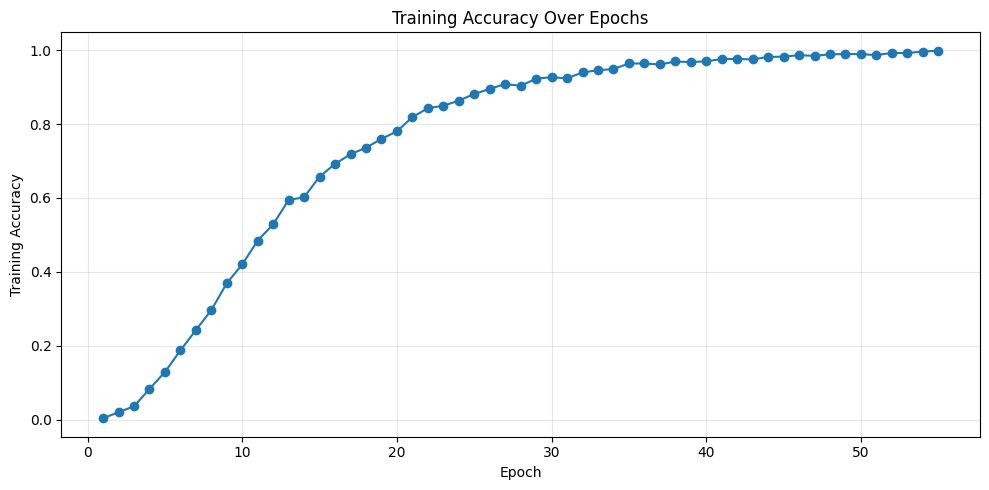

In [ ]:
import matplotlib.pyplot as plt

def plot_training_accuracy(history_frozen, history_finetune):
    train_acc = history_frozen.history["accuracy"] + history_finetune.history["accuracy"]
    epochs = range(1, len(train_acc) + 1)

    plt.figure(figsize=(10, 5))
    plt.plot(epochs, train_acc, marker="o", label="Training Accuracy")
    plt.title("Training Accuracy Over Epochs")
    plt.xlabel("Epoch")
    plt.ylabel("Training Accuracy")
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

plot_training_accuracy(history_frozen, history_finetune)


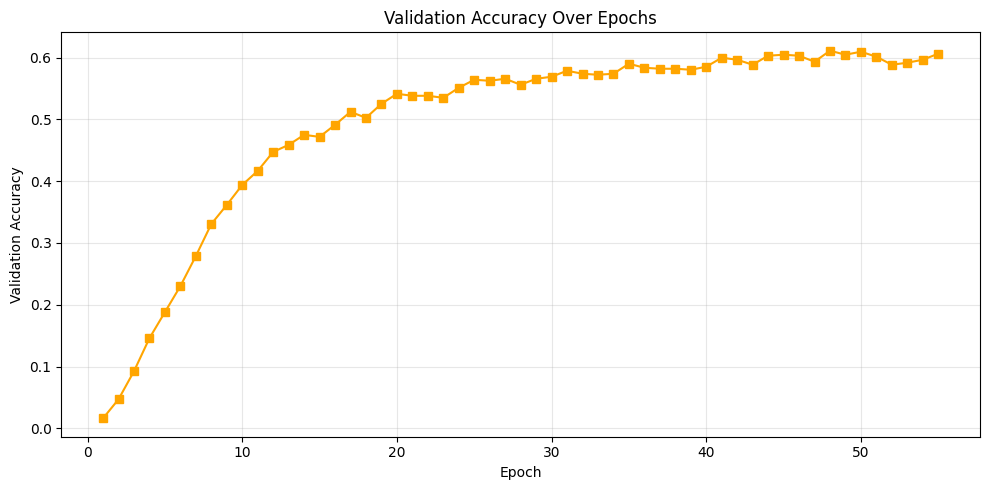

In [ ]:
def plot_validation_accuracy(history_frozen, history_finetune):
    val_acc = history_frozen.history["val_accuracy"] + history_finetune.history["val_accuracy"]
    epochs = range(1, len(val_acc) + 1)

    plt.figure(figsize=(10, 5))
    plt.plot(epochs, val_acc, marker="s", color="orange", label="Validation Accuracy")
    plt.title("Validation Accuracy Over Epochs")
    plt.xlabel("Epoch")
    plt.ylabel("Validation Accuracy")
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

plot_validation_accuracy(history_frozen, history_finetune)
